In [1]:
import pandas as pd
import numpy as np


In [11]:
!pip3 install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/6d/d1/3e954de1d492129710e8625349a7b86eb287a4f413c5b5c15522f89a6c04/xgboost-2.0.0-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.4 MB/s eta 0:00:00a 0:00:01


In [2]:
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
data = pd.read_csv('housing.csv')

data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [5]:
in_list = ['<1H OCEAN','INLAND']

df = data[data['ocean_proximity'].isin(in_list)]

df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64

In [6]:
def data_prep(df):
    df_x = df.copy()
    df_x = df.fillna(0)
    df_x['median_house_log'] = np.log1p(df.median_house_value.values)

    return df_x


In [7]:
df_prep = data_prep(df)

In [8]:
df_prep.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_house_log
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN,12.973866
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN,12.287657
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN,12.419574
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN,12.554971
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN,12.287196


In [9]:
df_train_full, df_test = train_test_split(df_prep, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.median_house_log.values
y_val = df_val.median_house_log.values
y_test = df_test.median_house_log.values

del df_train['median_house_log']
del df_train['median_house_value']
del df_val['median_house_log']
del df_val['median_house_value']
del df_test['median_house_log']
del df_test['median_house_value']

In [10]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20101,-120.25,37.93,13.0,493.0,76.0,196.0,68.0,3.3750,INLAND
5495,-118.40,34.00,10.0,1526.0,339.0,705.0,268.0,5.8083,<1H OCEAN
19723,-121.67,38.85,46.0,645.0,131.0,410.0,122.0,1.7417,INLAND
7876,-118.14,33.88,24.0,3305.0,982.0,2085.0,881.0,2.6641,<1H OCEAN
7684,-118.11,33.92,34.0,1414.0,263.0,983.0,264.0,4.1767,<1H OCEAN


In [11]:
dv = DictVectorizer(sparse=True)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [18]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=1)

In [19]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1 )
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [23]:
y_pred = rf.predict(X_val)

score = mean_squared_error(y_val, y_pred, squared=False)
print(f'RMSE = {score}')

RMSE = 0.24494586188945516


In [26]:
scores = []
for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = mean_squared_error(y_val, y_pred, squared=False)

        scores.append((n, score))

In [33]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [34]:
df_scores['rmse'] =  df_scores['rmse'].round(3)

In [35]:
df_scores

,n_estimators,rmse
0,10,0.245
1,20,0.239
2,30,0.237
3,40,0.235
4,50,0.235
5,60,0.234
6,70,0.234
7,80,0.234
8,90,0.234
9,100,0.234


In [37]:
scores = []
depths = [10,15,20, 25]

for d in depths:
    for n in range(10, 201, 10):
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=d,
                                        random_state=1,
                                        n_jobs=-1)
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_val)
            score = mean_squared_error(y_val, y_pred, squared=False)

            scores.append((n, d, score))

In [38]:
columns = ['n_estimators','max_depth','rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [41]:
df_scores.sort_values('rmse').head(30) 

,n_estimators,max_depth,rmse
56,170,20,0.233415
55,160,20,0.233449
76,170,25,0.233510
75,160,25,0.233513
54,150,20,0.233541
53,140,20,0.233579
57,180,20,0.233600
74,150,25,0.233674
59,200,20,0.233684
77,180,25,0.233726


In [42]:
rf = RandomForestRegressor(n_estimators=10,
                                       max_depth=20,
                                        random_state=1,
                                        n_jobs=-1)

In [44]:
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.01552689, 0.030003  , 0.10185539, 0.08636743, 0.33556349,
       0.29247297, 0.07380644, 0.02735301, 0.01532831, 0.02172307])

In [47]:
fet_ind = np.argsort(rf.feature_importances_)[::-1]
fet_imp = rf.feature_importances_[fet_ind]

In [48]:
fet_imp

array([0.33556349, 0.29247297, 0.10185539, 0.08636743, 0.07380644,
       0.030003  , 0.02735301, 0.02172307, 0.01552689, 0.01532831])

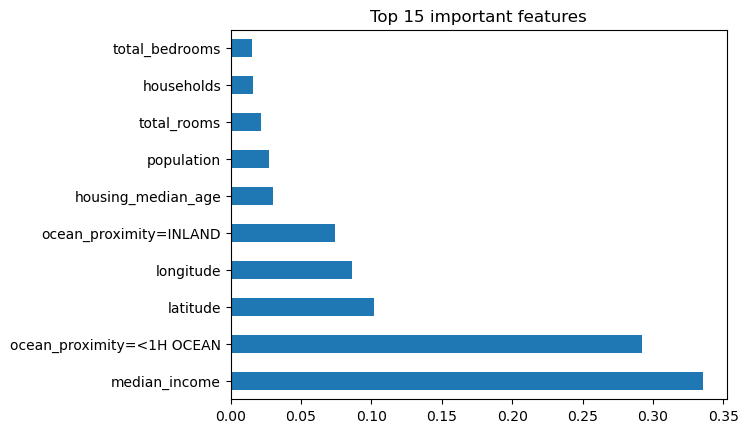

In [55]:
feat_importances = pd.Series(rf.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()


Question 6: XGboost

In [58]:
import xgboost as xgb

In [62]:
features_n

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

In [17]:
features_n = dv.get_feature_names_out()

features_n

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [20]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [21]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [22]:
y_pred = model.predict(dval)

In [24]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [25]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 verbose_eval=5,
                  evals=watchlist)

In [26]:
s = output.stdout

In [28]:
print(s)

[0]	train-rmse:0.44350	val-rmse:0.44250
[5]	train-rmse:0.25338	val-rmse:0.27463
[10]	train-rmse:0.21444	val-rmse:0.25179
[15]	train-rmse:0.19858	val-rmse:0.24522
[20]	train-rmse:0.18524	val-rmse:0.23978
[25]	train-rmse:0.17757	val-rmse:0.23830
[30]	train-rmse:0.16888	val-rmse:0.23570
[35]	train-rmse:0.16113	val-rmse:0.23416
[40]	train-rmse:0.15542	val-rmse:0.23318
[45]	train-rmse:0.14941	val-rmse:0.23190
[50]	train-rmse:0.14536	val-rmse:0.23225
[55]	train-rmse:0.14150	val-rmse:0.23197
[60]	train-rmse:0.13719	val-rmse:0.23139
[65]	train-rmse:0.13259	val-rmse:0.23158
[70]	train-rmse:0.12943	val-rmse:0.23068
[75]	train-rmse:0.12555	val-rmse:0.23039
[80]	train-rmse:0.12192	val-rmse:0.22886
[85]	train-rmse:0.11854	val-rmse:0.22888
[90]	train-rmse:0.11496	val-rmse:0.22861
[95]	train-rmse:0.11211	val-rmse:0.22908
[99]	train-rmse:0.10989	val-rmse:0.22862



In [29]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 verbose_eval=5,
                  evals=watchlist)

In [30]:
s = output.stdout

In [31]:
print(s)

[0]	train-rmse:0.52449	val-rmse:0.52045
[5]	train-rmse:0.37822	val-rmse:0.38151
[10]	train-rmse:0.30326	val-rmse:0.31427
[15]	train-rmse:0.26538	val-rmse:0.28380
[20]	train-rmse:0.24512	val-rmse:0.26882
[25]	train-rmse:0.23026	val-rmse:0.25997
[30]	train-rmse:0.21887	val-rmse:0.25266
[35]	train-rmse:0.21020	val-rmse:0.24826
[40]	train-rmse:0.20392	val-rmse:0.24539
[45]	train-rmse:0.19814	val-rmse:0.24293
[50]	train-rmse:0.19215	val-rmse:0.24020
[55]	train-rmse:0.18809	val-rmse:0.23878
[60]	train-rmse:0.18457	val-rmse:0.23791
[65]	train-rmse:0.18063	val-rmse:0.23698
[70]	train-rmse:0.17741	val-rmse:0.23622
[75]	train-rmse:0.17468	val-rmse:0.23510
[80]	train-rmse:0.17242	val-rmse:0.23453
[85]	train-rmse:0.17014	val-rmse:0.23404
[90]	train-rmse:0.16797	val-rmse:0.23332
[95]	train-rmse:0.16562	val-rmse:0.23276
[99]	train-rmse:0.16323	val-rmse:0.23209



In [32]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [33]:

df_score = parse_xgb_output(output)

In [35]:
scores = {}

In [36]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 verbose_eval=5,
                  evals=watchlist)

In [37]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [40]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 verbose_eval=5,
                  evals=watchlist)

In [41]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [46]:
scores

{'eta=0.3':     num_iter  train_auc  val_auc
 0          0    0.44350  0.44250
 1          5    0.25338  0.27463
 2         10    0.21444  0.25179
 3         15    0.19858  0.24522
 4         20    0.18524  0.23978
 5         25    0.17757  0.23830
 6         30    0.16888  0.23570
 7         35    0.16113  0.23416
 8         40    0.15542  0.23318
 9         45    0.14941  0.23190
 10        50    0.14536  0.23225
 11        55    0.14150  0.23197
 12        60    0.13719  0.23139
 13        65    0.13259  0.23158
 14        70    0.12943  0.23068
 15        75    0.12555  0.23039
 16        80    0.12192  0.22886
 17        85    0.11854  0.22888
 18        90    0.11496  0.22861
 19        95    0.11211  0.22908
 20        99    0.10989  0.22862,
 'eta=0.1':     num_iter  train_auc  val_auc
 0          0    0.52449  0.52045
 1          5    0.37822  0.38151
 2         10    0.30326  0.31427
 3         15    0.26538  0.28380
 4         20    0.24512  0.26882
 5         25    0.23026 

In [47]:
scores['eta=0.3']

,num_iter,train_auc,val_auc
0,0,0.44350,0.44250
1,5,0.25338,0.27463
2,10,0.21444,0.25179
3,15,0.19858,0.24522
4,20,0.18524,0.23978
5,25,0.17757,0.23830
6,30,0.16888,0.23570
7,35,0.16113,0.23416
8,40,0.15542,0.23318
9,45,0.14941,0.23190


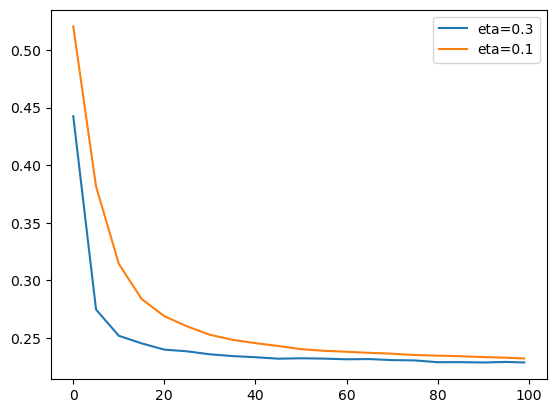

In [48]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()